## Imports

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 126 kB/s 


In [2]:
# Basics
import pandas as pd
import numpy as np
# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set()
#Catboost
from catboost import CatBoostClassifier, CatBoostRegressor
#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Load the Dataset

In [3]:
df = pd.read_csv('/content/WorldCupMatches.csv')

# Change column names
df.columns = ['Year', 'Date', 'stage', 'home_team', 'home_team_goals', 'away_team_goals', 'away_team', 'win_cond', 'home_team_cd', 'away_team_cd']

In [4]:
from datetime import datetime
# Correcting data types
col_types = {
    'Year' : 'int',
    'home_team_goals' : 'int',
    'away_team_goals' : 'int'  
}

# Change col types
df = df.astype(col_types)

# Change Date to Datetime
df['Date'] = pd.to_datetime(df['Date'])

# Check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Year             916 non-null    int64         
 1   Date             916 non-null    datetime64[ns]
 2   stage            916 non-null    object        
 3   home_team        916 non-null    object        
 4   home_team_goals  916 non-null    int64         
 5   away_team_goals  916 non-null    int64         
 6   away_team        916 non-null    object        
 7   win_cond         856 non-null    object        
 8   home_team_cd     916 non-null    object        
 9   away_team_cd     916 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 71.7+ KB


In [5]:
df.head()

,Year,Date,stage,home_team,home_team_goals,away_team_goals,away_team,win_cond,home_team_cd,away_team_cd
0,1930,1930-07-13,Group 1,France,4,1,Mexico,,FRA,MEX
1,1930,1930-07-13,Group 4,USA,3,0,Belgium,,USA,BEL
2,1930,1930-07-14,Group 2,Yugoslavia,2,1,Brazil,,YUG,BRA
3,1930,1930-07-14,Group 3,Romania,3,1,Peru,,ROU,PER
4,1930,1930-07-15,Group 1,Argentina,1,0,France,,ARG,FRA


# Exploring the Data

### **Is the home factor important in World Cup?** 
The first exploration we're going to do is to check if the home/ away factor is important. Usually that plays a significant role in football.

In [6]:
# Creating the result column with -1 (home team lost), 0 (draw), 1 (home team won)
conditions = [ df.home_team_goals > df.away_team_goals,
               df.home_team_goals == df.away_team_goals,
              df.home_team_goals < df.away_team_goals ]
vals = [1,0,-1]

df['result'] = np.select(conditions, vals)

In [7]:
home_away_factor = (
    df['result']
    .value_counts(normalize=True)
    .to_frame()
    .reset_index()
    .rename(columns={'index':'result', 'result': 'pct'})
    .replace({ 1:'home', -1:'away', 0:'draw'})
 )

# Plot
(px
 .bar(data_frame= home_away_factor,
       x='result', y= 'pct',
      height=400, width=800))

We can see from the data from all tournaments that the *home team* usually wins. It's 56% of the times. Therefore, an important factor to consider for modeling. So, the labeling for the classification can be 
* (1) for home team victory
* (0) draw
* (-1) home team loss / away team victory

### Let's make changes in the stage variable
For games in the first stage of the championship, we want to make if called *Groups*.

In [8]:
# Wherever the stage variable does not have Group in the name, it stays the same. Other cases, change to just "Group".
df['stage'] = df['stage'].where(~df.stage.str.contains('Group'), other='Group')

### **Rank the teams by performance**
Next, let's extract some insights from the data and try to rank the teams by performance. We will create the following measurements: 
* Games played
* Wins at home
* Wins away
* Losses home
* Losses away
* Goals in favor [GF]
* Goals against [GA]
* Overall performance (victories/games played)

In [9]:
# Creating datasets for performance of the teams at home games
home_victories = df.query('result==1').groupby('home_team_cd')['result'].count().sort_values(ascending=False).reset_index()
home_losses = df.query('result==-1').groupby('home_team_cd')['result'].count().sort_values(ascending=False).reset_index()
home_gf = df.groupby('home_team_cd').home_team_goals.sum().sort_values(ascending=False).reset_index()
home_ga = df.groupby('home_team_cd').away_team_goals.sum().sort_values(ascending=False).reset_index()
home_avg_goals = df.groupby('home_team_cd').home_team_goals.mean()

# Creating datasets for performance of the teams at aways games
away_victories = df.query('result==-1').groupby('away_team_cd')['result'].count().sort_values(ascending=False).reset_index()
away_losses = df.query('result==1').groupby('away_team_cd')['result'].count().sort_values(ascending=False).reset_index()
away_gf = df.groupby('away_team_cd').away_team_goals.sum().sort_values(ascending=False).reset_index()
away_ga = df.groupby('away_team_cd').home_team_goals.sum().sort_values(ascending=False).reset_index()
away_avg_goals = df.groupby('away_team_cd').away_team_goals.mean()

# Qty games played
games = {team:df.query('away_team_cd == @team | home_team_cd == @team')['result'].count() for team in df.home_team_cd.unique()}
games = pd.DataFrame.from_dict(games, orient='index').reset_index().rename(columns={'index': 'team', 0:'games'})

In [10]:
# Create winner and loser variables
conds = [ df.result == 1,
          df.result == 0,
          df.result == -1 ]
vals_winner = [df.home_team_cd, 'draw', df.away_team_cd]
vals_loser = [df.away_team_cd, 'draw', df.home_team_cd]

df['winner'] = np.select(conds, vals_winner)
df['loser'] = np.select(conds, vals_loser)

In [11]:
# Creating performance measurements wins and losses
teams_performance = pd.DataFrame({'team': df.home_team_cd.unique()})

# Games Played
teams_performance = (
    teams_performance
    .merge(games, on='team',how='left')
    .fillna(0))

# Add home wins
teams_performance = (
    teams_performance
    .merge(home_victories, left_on='team', right_on='home_team_cd', how='left')
    .fillna(0)
    .drop('home_team_cd', axis=1)
    .rename(columns={'result':'home_wins'}) )

# Add away wins
teams_performance = (
    teams_performance
    .merge(away_victories, left_on='team', right_on='away_team_cd', how='left')
    .fillna(0)
    .drop('away_team_cd', axis=1)
    .rename(columns={'result':'away_wins'}) )

# Add home losses
teams_performance = (
    teams_performance
    .merge(home_losses, left_on='team', right_on='home_team_cd', how='left')
    .fillna(0)
    .drop('home_team_cd', axis=1)
    .rename(columns={'result':'home_losses'}) )

# Add away losses
teams_performance = (
    teams_performance
    .merge(away_losses, left_on='team', right_on='away_team_cd', how='left')
    .fillna(0)
    .drop('away_team_cd', axis=1)
    .rename(columns={'result':'away_losses'}) )

# Add home GF
teams_performance = (
    teams_performance
    .merge(home_gf, left_on='team', right_on='home_team_cd', how='left')
    .fillna(0)
    .drop('home_team_cd', axis=1)
    .rename(columns= {'home_team_goals':'home_gf'}) )

# Add home GA
teams_performance = (
    teams_performance
    .merge(home_ga, left_on='team', right_on='home_team_cd', how='left')
    .fillna(0)
    .drop('home_team_cd', axis=1)
    .rename(columns= {'away_team_goals':'home_ga'}) )

# Add Away GF
teams_performance = (
    teams_performance
    .merge(away_gf, left_on='team', right_on='away_team_cd', how='left')
    .fillna(0)
    .drop('away_team_cd', axis=1)
    .rename(columns= {'away_team_goals':'away_gf'}) )

# Add Away GA
teams_performance = (
    teams_performance
    .merge(away_ga, left_on='team', right_on='away_team_cd', how='left')
    .fillna(0)
    .drop('away_team_cd', axis=1)
    .rename(columns= {'home_team_goals':'away_ga'}) )

# Add Overal performance = [Home Wins + Away Wins]/[Games Played]
teams_performance['performance'] = (
    teams_performance['home_wins'].add(teams_performance['away_wins']).div(teams_performance['games']))

# Add Qatar
teams_performance.loc[len(teams_performance.index)] = ['QTR',0,0,0,0,0,0,0,0,0,0]

# Teams Performance Dataset
teams_performance.sort_values(by='performance', ascending=False).head()

,team,games,home_wins,away_wins,home_losses,away_losses,home_gf,home_ga,away_gf,away_ga,performance
7,BRA,113,61.0,13.0,10.0,10.0,186,81,47,36,0.654867
13,GER,118,56.0,17.0,8.0,16.0,173,72,69,60,0.618644
15,ITA,83,38.0,7.0,5.0,12.0,99,41,29,36,0.542169
33,NED,54,18.0,11.0,4.0,7.0,51,21,40,28,0.537037
4,ARG,85,41.0,4.0,9.0,15.0,112,48,27,46,0.529412


### Visualizations

Out of the teams that ever played in a World Cup, here are the top performers in terms of wins over games played

In [ ]:
# Teams that win more
px.bar(data_frame=teams_performance.sort_values('performance', ascending=False).head(25),
       x='team', y= 'performance',
       height=500, width=1000)

In [ ]:
# Choosing only data from 1990
df2 = df.query('Year > 1990').reset_index(drop=True)
#df2.query('Year >= 2014')

In [ ]:
# Distribution of victories by stage
# -1: away victory | 0: draw | 1: home victory
wins_by_stage = (
    df2
    .groupby('stage').result
    .value_counts(normalize=True)
    .to_frame()
    .rename(columns={'result':'pct'})
    .reset_index()
    .astype({'result': 'object'})  )

px.bar(wins_by_stage,
       x='stage', y= 'pct',
       color= 'result', barmode='group',
       title='Distribution of victories by stage',
       height=500, width=1200)

We see here that the home team wins more in most of the cases. The Group stage, the Final and Quarter-Finals are very similar, actually. The Round of 16 has a much higher amount of victories of home teams, usually because these games are the 1st of a group (home) vs the second of another group (away). The group leader tend to be a stronger team.

# Modeling

As football and the teams changed so much in the last years, we're going to consider only data from 1990 on for training. So, let's filter it.

In [36]:
# Choosing only data from 1990
df2 = df.query('Year > 1990').reset_index(drop=True)
#df2.query('Year >= 2014')

### Catboost

Now that we have explored the data and created some performance metrics to serve as input, let's start modeling our data.

In [13]:
# Check where the 2014 data starts
test_index = df2.query('Year == 2014').index.min()

In [14]:
# Let's create an input dataset for the model
df_input = df2[['stage', 'home_team_cd', 'away_team_cd', 'result', 'home_team_goals', 'away_team_goals']]
df_input = (
    df_input
    .merge(teams_performance, left_on= 'home_team_cd', right_on='team', how='left').fillna(0)
    .merge(teams_performance, left_on= 'away_team_cd', right_on='team', suffixes=['_home','_away'], how='left').fillna(0) )
df_input.drop(['team_home', 'team_away'], axis=1, inplace=True)

In [15]:
train = df_input.iloc[:test_index,:]
test = df_input.iloc[test_index:,:]

Now we will use CatBoost for modeling

In [19]:
# Categorical Features
"CatBoost needs to know which features are categorical"
cat_features = df_input.select_dtypes(include='object').columns.values
#cat_features = [df_input.columns.get_loc(c) for c in cat_features]

X = train.drop(['home_team_goals','away_team_goals','result'], axis=1)
y = train.result
Xt = test.drop(['home_team_goals','away_team_goals','result'], axis=1)
yt = test.result

In [20]:
X.columns

Index(['stage', 'home_team_cd', 'away_team_cd', 'games_home', 'home_wins_home',
       'away_wins_home', 'home_losses_home', 'away_losses_home',
       'home_gf_home', 'home_ga_home', 'away_gf_home', 'away_ga_home',
       'performance_home', 'games_away', 'home_wins_away', 'away_wins_away',
       'home_losses_away', 'away_losses_away', 'home_gf_away', 'home_ga_away',
       'away_gf_away', 'away_ga_away', 'performance_away'],
      dtype='object')

In [21]:
# Catboost
model = CatBoostClassifier(iterations=10000, learning_rate=0.55)
model.fit(X, y, cat_features= cat_features, verbose=2000)

0:	learn: 0.9530572	total: 50.7ms	remaining: 8m 27s
2000:	learn: 0.0026780	total: 7s	remaining: 28s
4000:	learn: 0.0012788	total: 19.2s	remaining: 28.8s
6000:	learn: 0.0008422	total: 33.4s	remaining: 22.2s
8000:	learn: 0.0006274	total: 41.3s	remaining: 10.3s
9999:	learn: 0.0005000	total: 48.2s	remaining: 0us


In [24]:
pred_train = model.predict(X) 
pred_test = model.predict(Xt)
# Test Score
f1_score(yt, pred_test, average=None)

array([0.6122449 , 0.24561404, 0.69172932])

In [ ]:
# Confusion Matrix Training
pd.DataFrame(confusion_matrix(y_true=y, y_pred=pred_train), 
             index=['away', 'draw', 'home'],
             columns=['away', 'draw', 'home'])

,away,draw,home
away,70,6,19
draw,9,62,6
home,11,7,118


In [25]:
# Confusion Matrix Test
pd.DataFrame(confusion_matrix(y_true=yt, y_pred=pred_test), 
             index=['away', 'draw', 'home'],
             columns=['away', 'draw', 'home'])

,away,draw,home
away,30,13,8
draw,7,7,16
home,10,7,46


### RandomForest

In [37]:
# Function to factorize categorical features
def encode_variables(df):
  "Input a dataframe and return a dataframe whith categorical variables encoded numericaly"
  # Find categorical vars
  cat_vars = df.select_dtypes(include=['object', 'category']).columns
  # Loop and transform
  for variable in cat_vars:
    df[variable] = df[variable].factorize()[0]
  
  return df

In [38]:
# Create a copy of X
X_rf = X.copy()
Xt_rf = Xt.copy()

In [39]:
# Encode categorical variables
X_rf = encode_variables(X_rf)

# Encode categorical variables
Xt_rf = encode_variables(Xt_rf)

In [40]:
# Variable importances
x_scaled = StandardScaler().fit_transform(X_rf)
dummy = RandomForestClassifier().fit(x_scaled, y)
dummy_importances = pd.DataFrame({'variables':X_rf.columns,
                                  'importance': dummy.feature_importances_}).sort_values(by='importance', ascending=False)
px.bar(dummy_importances,
       x= 'variables', y='importance',
       height=500, width=1000)

In [91]:
sc = []
for r in range(15,100):
  steps = [
    ('scale', StandardScaler()),
    ('model', RandomForestClassifier(random_state=r))
]

  # Final Pipeline
  model_rf = Pipeline( steps )
# Fit
  model_rf.fit(X_rf, y)
  m = model_rf.score(Xt_rf,yt)
  sc.append((r, m))


In [94]:
# Steps
steps = [
    ('scale', StandardScaler()),
    ('model', RandomForestClassifier(random_state=79))
]

# Final Pipeline
model_rf = Pipeline( steps )
# Fit
model_rf.fit(X_rf, y)

Pipeline(steps=[('scale', StandardScaler()),
                ('model', RandomForestClassifier(random_state=79))])

In [95]:
# Model score
print(model_rf.score(X_rf,y))
print(model_rf.score(Xt_rf,yt))

0.9837662337662337
0.5902777777777778


In [96]:
# Model predictions
pred_rf_test = model_rf.predict(Xt_rf)

In [97]:
# Test confusion matrix
pd.DataFrame(confusion_matrix(y_true=yt, y_pred=pred_rf_test), 
             index=['away', 'draw', 'home'],
             columns=['away', 'draw', 'home'])

,away,draw,home
away,31,11,9
draw,7,6,17
home,7,8,48


In [98]:
# F1 score
f1_score(y_true=yt, y_pred=pred_rf_test, average=None)

array([0.64583333, 0.21818182, 0.70072993])

## Voting Classifier
Let's try to improve even more with a Voting Classifier composed by Logistic Regression and Random Forest

In [46]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import VotingClassifier

In [47]:
# Models instances
logit = LogisticRegression(max_iter=10000, multi_class='multinomial')
rf = RandomForestClassifier(criterion='entropy', n_estimators=600, max_depth=3)
gb = GradientBoostingClassifier(learning_rate=0.3, n_estimators=10000)

In [48]:
# Voting Classifier
voting = VotingClassifier(estimators=[
          ('lr', logit),
          ('rf', rf) ],
           voting='soft')

In [49]:
# Fit
voting.fit(X_rf, y)
voting.score(X_rf, y)
voting.score(Xt_rf, yt)

0.6319444444444444

In [50]:
# F1 score
pred_voting = voting.predict(Xt_rf)
f1_score(y_true=yt, y_pred=pred_voting, average=None)

array([0.66      , 0.22222222, 0.74125874])

# Test Predictions 2022 World Cup

In [ ]:
match = pd.DataFrame({'stage': ['Group','Group','Group','Group'], 
                      'home_team_cd': ['QTR', 'ENG', 'SEN', 'USA'], 
                      'away_team_cd': ['ECU', 'IRN', 'NED', 'WAL']
                      })

In [ ]:
# Let's create an input dataset for the model
X_input = (
    match
    .merge(teams_performance, left_on= 'home_team_cd', right_on='team', how='left').fillna(0)
    .merge(teams_performance, left_on= 'away_team_cd', right_on='team', suffixes=['_home','_away'], how='left').fillna(0) )
X_input.drop(['team_home', 'team_away'], axis=1, inplace=True)

X_input = encode_variables(X_input)

In [ ]:
# Results with CatBoost
model.predict_proba(X_input)

array([[4.47375979e-01, 5.51830826e-01, 7.93194514e-04],
       [1.92673903e-04, 1.96686385e-02, 9.80138688e-01],
       [9.97765422e-01, 1.99394818e-03, 2.40630300e-04],
       [9.33053210e-02, 6.50777704e-01, 2.55916975e-01]])

In [ ]:
# Results with Random Forest
model_rf.predict_proba(X_input)

array([[0.44333333, 0.41      , 0.14666667],
       [0.15      , 0.175     , 0.675     ],
       [0.66      , 0.17      , 0.17      ],
       [0.34333333, 0.24      , 0.41666667]])

In [ ]:
# Results with Voting Classifier
voting.predict_proba(X_input)

array([[0.37620159, 0.18613142, 0.43766699],
       [0.08186811, 0.24952196, 0.66860993],
       [0.64789936, 0.16354713, 0.18855351],
       [0.33717441, 0.17541114, 0.48741445]])

 # Modeling Goals scored

In [136]:
# Goals Scored and Conceded
home_df = df[['home_team_cd', 'home_team_goals', 'away_team_goals']].rename(columns={'home_team_cd': 'team', 'home_team_goals': 'gf', 'away_team_goals':'ga'})
home_df['total'] = home_df.gf + home_df.ga
away_df = df[['away_team_cd', 'home_team_goals', 'away_team_goals']].rename(columns={'away_team_cd': 'team', 'home_team_goals': 'ga', 'away_team_goals':'gf'})
away_df['total'] = away_df.gf + away_df.ga

# gather datasets
#df_goals = pd.concat([home_df, away_df], ignore_index=True).groupby('team').agg(['mean', 'std']).reset_index()
#df_goals.columns = ['team', 'gf_mean', 'gf_std', 'ga_mean', 'ga_std']
df_goals = pd.concat([home_df, away_df], ignore_index=True).groupby('team').mean().reset_index()

In [140]:
# View
df_goals.sample(3)

,team,gf,ga,total,performance,strength
3,AUS,0.812500,1.937500,2.750000,0.125000,0.419355
26,GER,2.033613,1.109244,3.142857,0.618644,1.833333
40,JPN,0.952381,1.380952,2.333333,0.238095,0.689655


In [138]:
# Adding performance to df_goals
df_goals = df_goals.merge(teams_performance[['team','performance']], on='team', how='left').fillna(0)
# Adding strength as [Goals in Favor]/[Goals Against]
df_goals['strength'] = df_goals['gf'].div(df_goals['ga'])

In [144]:
# Add QTR
df_goals.loc[len(df_goals.index)] = ['QTR', 0, 0, 0.05, 0.01, 0.01]

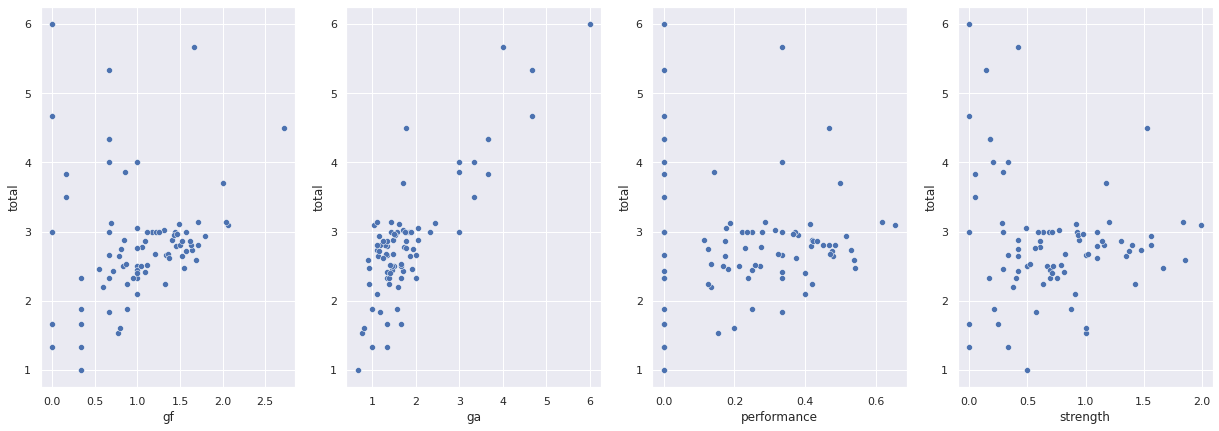

In [143]:
plt.figure(figsize=(21,7))
plt.subplot(141)
sns.scatterplot(data=df_goals, x='gf', y='total')
plt.subplot(142)
sns.scatterplot(data=df_goals, x='ga', y='total')
plt.subplot(143)
sns.scatterplot(data=df_goals, x='performance', y='total')
plt.subplot(144)
sns.scatterplot(data=df_goals, x='strength', y='total');

In [154]:
df_goals.corr().style.background_gradient(cmap='coolwarm')

,gf,ga,total,performance,strength
gf,1.000000,-0.371805,0.200660,0.888251,0.882207
ga,-0.371805,1.000000,0.834809,-0.467977,-0.568580
total,0.200660,0.834809,1.000000,0.032884,-0.077189
performance,0.888251,-0.467977,0.032884,1.000000,0.910851
strength,0.882207,-0.568580,-0.077189,0.910851,1.000000


In [145]:
# Import Support Vector Regressor to model the total goals in a match
from sklearn.svm import SVR

In [159]:
# Prepare X and y inputs for training
Xg = df_goals.drop(['team','total'], axis=1)
yg = df_goals.total

In [175]:
# Data preparation for prediction of total goals in the match
my_input = df_goals.query('team in ["BRA", "ITA"]').drop(['team', 'total'], axis=1).reset_index(drop=True)
my_input.loc[len(my_input.index)] = [1.895, 1.58, 0.55, 1.82]
my_input

,gf,ga,performance,strength
0,2.061947,1.035398,0.654867,1.991453
1,1.542169,0.927711,0.542169,1.662338
2,1.895000,1.580000,0.550000,1.820000


In [176]:
# RMSE Goal Model
goal_model = SVR(C=1.0, kernel='poly', degree=1)
goal_model.fit(Xg, yg)
rmse = np.sqrt( mean_squared_error( y_true=yg,
                            y_pred= goal_model.predict(Xg)) )
rmse

0.053057578470099995

In [177]:
# Variance of RMSE over the original mean
rmse / df_goals.total.mean()

0.01882896905418355

In [178]:
# Test prediction
goal_model.predict(my_input.iloc[2:,:])

array([3.52683536])

The model to predict the total number of goals in a match is trained and next we're going to create some formulas to get the results

In [ ]:
# Function to predict the total of goals in a match
def match_goals(home, away, h_win, a_win, draw):
  '''Predict the total goals for each team in a match. 
  Input:
  * home: str = code of the home team (e.g. "USA")
  * away: str =  code of the away team (e.g. "ENG")
  * h_win: float = % chance of home team win
  * a_win: float =  % chance of away team win
  * draw: float = % chance of draw.
  Returns:
  tuple with (goals_home, goals_away)
  '''
  # Check if the teams are in the goals dataframe
  if home in df_goals['team'].values and away in df_goals['team'].values:
    # Create dataframe with two teams
    my_input = df_goals.query('team in [@home, @away]').drop(['team', 'total'], axis=1).reset_index(drop=True)
    # Create the input
    # We will use these calculations
    # home_GF * away_GA, home_GA * away_GF, avg_performance, avg_strength
    my_input.loc[len(my_input.index)] = [my_input.iloc[0,0] * my_input.iloc[1,1],
                                         my_input.iloc[0,1] * my_input.iloc[1,0],
                                         np.mean([my_input.iloc[0,2], my_input.iloc[1,2]]),
                                         np.mean([my_input.iloc[0,3], my_input.iloc[1,3]])]
    # Input to the model
    my_input = my_input.iloc[2:,:]

    # Prediction with SVR model
    total_goals = goal_model.predict(my_input)
    total_goals = total_goals[0]

    # home win, draw or away_win
    result = np.argmax([a_win, draw, h_win])

    # Home Win and total goals 2 or less
    if (total_goals <= 2) & (result == 2):
      return (round(total_goals), 0)
    # Away Win and total goals 2 or less
    elif (total_goals <= 2) & (result == 0):
      return (0, round(total_goals))
    # Draw goals scored must be equal
    elif result == 1:
      goal = np.max([total_goals * h_win, total_goals * a_win])
      return (round(goal), round(goal))
     # Total goals more than 2
    elif (total_goals > 2):
      return (round(total_goals * h_win), round(total_goals * a_win))

  else:
    return (0, 0)

### Test Function total goals in match

In [ ]:
match_goals("QTR", "ECU", 0.166667, 0.463333, 0.370000)

(0, 1)

# Final Prediction of the World Cup
The final part of this project is to predict all the results and match results.
We will start with the Group Stage and will move on to the next pieces.

### Predictions

In [119]:
# Load fixtures file
#match = pd.read_csv('/content/fifa2022_matches.csv')
match = pd.read_csv('/content/group_stage_fifa2022_matches.csv')

In [121]:
# Let's create an input dataset for the model
X_input = (
    match
    .merge(teams_performance, left_on= 'home_team_cd', right_on='team', how='left').fillna(0)
    .merge(teams_performance, left_on= 'away_team_cd', right_on='team', suffixes=['_home','_away'], how='left').fillna(0) )
X_input.drop(['team_home', 'team_away'], axis=1, inplace=True)

X_input = encode_variables(X_input)

In [113]:
# Results with Random Forest
#preds = model_rf.predict_proba(X_input)

In [114]:
# Results with the Voting Classifier
preds = voting.predict_proba(X_input)

In [115]:
# Predictions of the results
match['away'] = pd.DataFrame(preds)[0]
match['draw'] = pd.DataFrame(preds)[1]
match['home'] = pd.DataFrame(preds)[2]

In [116]:
def points(df):
  "This function takes the dataframe with matches results prediction and returns the points each team has made"
  # Create dictionary with teams and points
  groups = {'QTR':0,'ECU':0,'SEN':0, 'NED':0,
            'ENG':0,'IRN':0,'USA':0, 'WAL':0,
            'ARG':0,'KSA':0,'MEX':0, 'POL':0,
            'DEN':0,'TUN':0,'FRA':0, 'AUS':0,
            'GER':0,'JPN':0,'CRC':0, 'ESP':0,
            'MAR':0,'CRO':0,'CAN':0, 'BEL':0,
            'SUI':0,'CMR':0,'BRA':0, 'SRB':0,
            'POR':0,'GHA':0,'URU':0, 'KOR':0          }
  # Loop through dataframe to find the winner and calculate points
  for game in df.itertuples():
    winner = np.argmax([game.away, game.draw, game.home])
    if winner == 0:
      groups[game.away_team_cd] += 3
    elif winner == 1:
      groups[game.home_team_cd] += 1
      groups[game.away_team_cd] += 1
    else:
      groups[game.home_team_cd] += 3

  # Return points
  return groups



### Group Stage

In [117]:
# Final Group Results
final_groups = (pd
          .DataFrame(points(match), index=[0])
          .T
          .reset_index()
          .rename(columns={'index': 'team', 0:'pts'})
)

# By Group
final_groups['group'] = ['A','A','A','A',
                         'B','B','B','B',
                         'C','C','C','C',
                         'D','D','D','D',
                         'E','E','E','E',
                         'F','F','F','F',
                         'G','G','G','G',
                         'H','H','H','H']

# Qualified for next round
(final_groups
 .groupby(['group', 'team'])
 .pts.sum()
 .groupby('group')
 .nlargest(2)
 .to_frame()
 )

pts
group group team     
A     A     NED     9
            ECU     3
B     B     ENG     7
            USA     5
C     C     ARG     9
            MEX     6
D     D     FRA     9
            DEN     6
E     E     GER     9
            ESP     6
F     F     BEL     9
            CRO     6
G     G     BRA     9
            SUI     4
H     H     URU     7
            POR     6

In [ ]:
# Predicting Goals scored each game
home_goals = []
away_goals = []
for m in match.itertuples():
  h_goals, a_goals = match_goals(m.home_team_cd, m.away_team_cd, m.home, m.away, m.draw)
  home_goals.append(h_goals)
  away_goals.append(a_goals)
match['home_goals'] = home_goals
match['away_goals'] = away_goals

In [ ]:
match.to_csv('predictionsFifa2022_voting.csv')

# Probability of a given result

In [ ]:
from scipy.stats import poisson

In [ ]:
df_goals2 = df_goals.set_index('team')

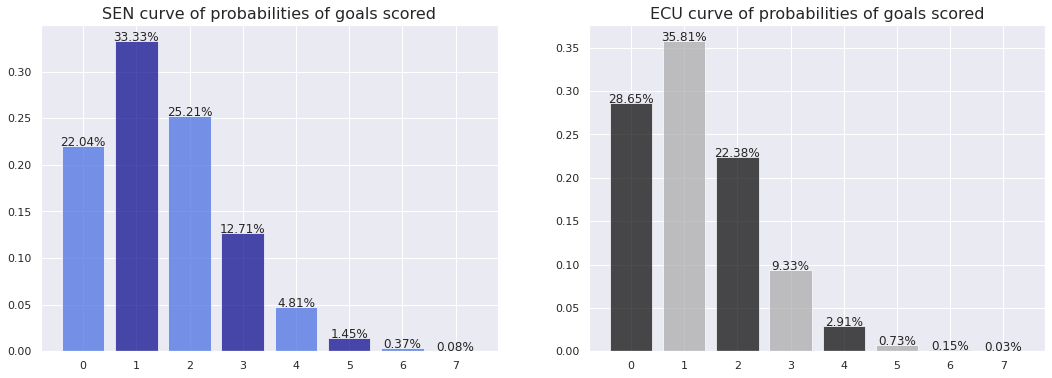

In [ ]:
home = "SEN"
away = "ECU"
lamb_home = df_goals2.at[home,'gf'] * df_goals2.at[away,'ga']
lamb_away = df_goals2.at[away,'gf'] * df_goals2.at[home,'ga']

p_home = [poisson.pmf(h_goals, lamb_home) for h_goals in range(8)]
p_away = [poisson.pmf(a_goals, lamb_away) for a_goals in range(8)]

# Plot both probability curves
plt.figure(figsize=(18,6))
# Plot Home Team
plt.subplot(121)
plt.bar(range(8), p_home, alpha=0.7, color=['royalblue', 'darkblue']);
plt.title(f'{home} curve of probabilities of goals scored', size=16)
for idx,p in enumerate(p_home):
  pct = f'{round(p*100,2)}%'
  plt.annotate(pct, xy=(idx, p), ha="center")

# Plot Away Team
plt.subplot(122)
plt.bar(range(8), p_away, alpha=0.7, color=['black', 'darkgray'])
plt.title(f'{away} curve of probabilities of goals scored', size=16)
for idx,p in enumerate(p_away):
  pct = f'{round(p*100,2)}%'
  plt.annotate(pct, xy=(idx, p), ha="center");

In [ ]:
0.1351*0.074

0.0099974